<a href="https://colab.research.google.com/github/stalin99835/DUDL/blob/main/dropout_iris_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from IPython import display



In [2]:
#import dataset
iris = sns.load_dataset('iris')
data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data),dtype=torch.long)

labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2
labels[iris.species=='setosa'] = 0

train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

batchsize = 16
#pytorch datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data = torch.utils.data.TensorDataset(test_data,test_labels)
#dataloader
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batchsize,shuffle=True)


In [3]:
class theModelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()

    # layers
    self.input = nn.Linear(4,12)
    self.hidden1 = nn.Linear(12,12)
    self.hidden2 = nn.Linear(12,12)
    self.output = nn.Linear(12,3)

    #parameters
    self.dropout = dropoutRate

  #forwrd pass
  def forward(self,x):
    #input
    x = F.relu(self.input(x))
    x = F.dropout(x,p=self.dropout,training=self.training)

    #hidden
    x = F.relu(self.hidden1(x))
    x = F.dropout(x,p=self.dropout,training=self.training)
    x = F.relu(self.hidden2(x))
    x = F.dropout(x,p=self.dropout,training=self.training)
    #output
    x = self.output(x)

    return x


In [4]:
#test
tmpnet = theModelClass(.25)

tmpdata = torch.randn(10,4)
yHat = tmpnet(tmpdata)
yHat

tensor([[-0.1081,  0.1243,  0.2267],
        [-0.1735,  0.1006,  0.2498],
        [-0.0746,  0.2935,  0.3253],
        [-0.1086,  0.2111,  0.2152],
        [-0.2363,  0.1954,  0.2448],
        [-0.1434,  0.1792,  0.2492],
        [-0.0817,  0.2294,  0.2135],
        [-0.1283,  0.1185,  0.1779],
        [-0.1045,  0.1440,  0.2609],
        [-0.0728,  0.1747,  0.3349]], grad_fn=<AddmmBackward0>)

In [5]:
def createModelInstance(dropoutrate):
  ANNIris = theModelClass(dropoutrate)
  #loss function
  lossfun = nn.CrossEntropyLoss()
  #optimizer
  optimizer = torch.optim.SGD(ANNIris.parameters(),lr=.005)
  return ANNIris,lossfun,optimizer



In [6]:
#train model
numepochs = 1000

def trainModel():
  trainAcc = []
  testAcc = []

  for epochi in range(numepochs):
    ANNIris.train() #switch on learning

    batchAcc = []

    for X,y in train_loader:
      #forward pass
      yHat = ANNIris(X)
      loss = lossfun(yHat,y)
      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())

      #end batch loop
    trainAcc.append(np.mean(batchAcc))

    #test accuracy
    ANNIris.eval()
    predlabels = torch.argmax(ANNIris(X),axis=1)
    testAcc.append(100*torch.mean((predlabels==y).float()).item())

  return(trainAcc,testAcc)


In [7]:
#create model
dropoutrate = 0.0
ANNIris,lossfun,optimizer = createModelInstance(dropoutrate)

#train model
trainAcc,testAcc = trainModel()

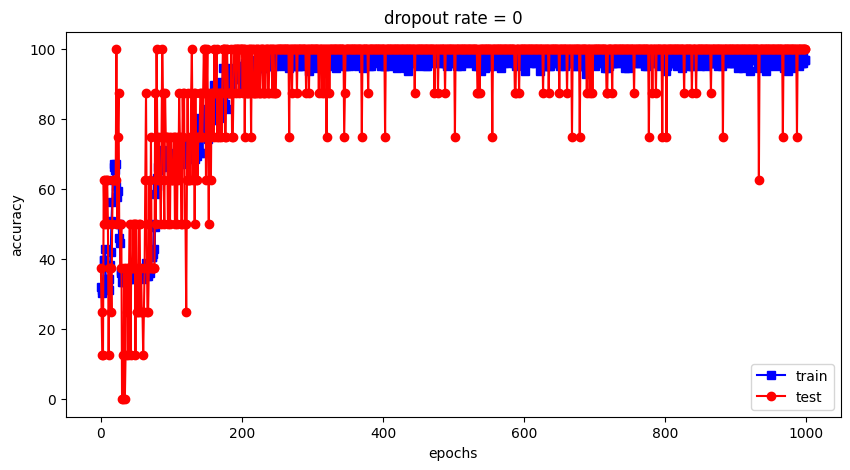

In [8]:
fig = plt.figure(figsize=(10,5))
plt.plot(trainAcc,'bs-',label='train acc')
plt.plot(testAcc,'ro-',label='test acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.title('dropout rate = %g' %(dropoutrate))

plt.show()


In [13]:
dropoutRates = np.arange(10)/10
results  = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):
  #create and train the model
  ANNIris,lossfun,optimizer = createModelInstance(dropoutRates[di])
  trainAcc,testAcc = trainModel()

  #store accuracies
  results[di,0] = np.mean(trainAcc[-50])
  results[di,1] = np.mean(testAcc[-50])


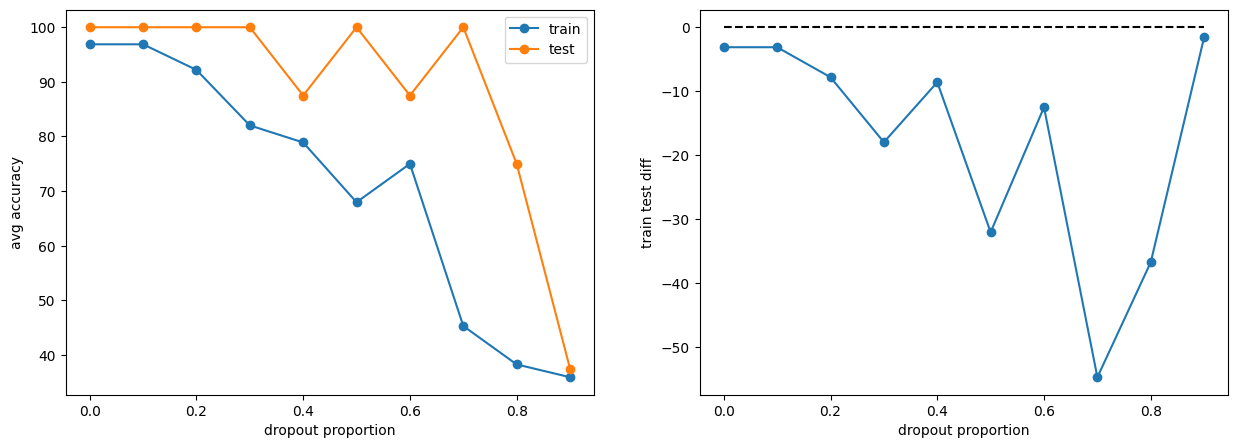

In [14]:
#plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('dropout proportion')
ax[0].set_ylabel('avg accuracy')
ax[0].legend(['train','test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('dropout proportion')
ax[1].set_ylabel('train test diff')
plt.show()